# Toy example, compare MLP and Ensemble NC

## Generate Data

Using gpu device 0: GeForce GT 630M (CNMeM is enabled with initial size: 75.0% of memory, CuDNN not available)


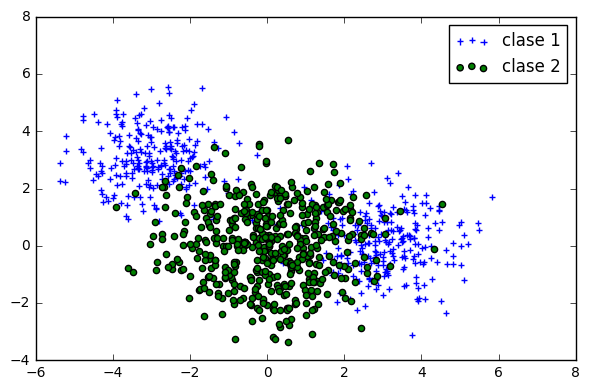

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy
from sklearn import svm
from sklearn import cross_validation
from theano import config

n_class1 = 500
n_class2 = 500

mu_vec11 = np.array([3,0])
cov_mat11 = np.array([[1,0],[0,1]])
x11 = np.random.multivariate_normal(mu_vec11, cov_mat11, n_class1 // 2)

mu_vec12 = np.array([-3,3])
cov_mat12 = np.array([[1,0],[0,1]])
x12 = np.random.multivariate_normal(mu_vec12, cov_mat12, n_class1 // 2)

x1_samples = np.concatenate((x11, x12))

mu_vec2 = np.array([0,0])
cov_mat2 = np.array([[2,0],[0,2]])
x2_samples = np.random.multivariate_normal(mu_vec2, cov_mat2, n_class2)
mu_vec2 = mu_vec2.reshape(1,2).T

fig = plt.figure()

plt.scatter(x1_samples[:,0],x1_samples[:,1], marker='+')
plt.scatter(x2_samples[:,0],x2_samples[:,1], c= 'green', marker='o')

X = np.array(np.concatenate((x1_samples,x2_samples), axis = 0), dtype=config.floatX)
Y = np.array([0]*n_class1 + [1]*n_class2, dtype=config.floatX)
classes_names = [0, 1]
labels = ['clase 1', 'clase 2']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.4, random_state=0)


plt.legend(labels)
plt.tight_layout()

## Training MLP

In [28]:
from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.utils import *
import theano.tensor as T

# create MLP
mlp = Sequential("mlp", "classifier", classes_names)
mlp.add_layer(Dense(n_input=X.shape[1], n_output=6, activation=T.tanh))
mlp.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.softmax))
mlp.append_cost(mse)
mlp.set_update(sgd, learning_rate=0.1)
mlp.compile(fast=True)

max_epoch = 200  # max epoch training

metrics_mlp = ClassifierMetrics(mlp)

metric = mlp.fit(X_train, y_train, max_epoch=max_epoch, batch_size=32)

metrics_mlp.append_prediction(y_test, mlp.predict(X_test))
metrics_mlp.append_metric(metric)

metrics_mlp.classification_report()

mlp - epoch:[####################] 200/200 elapsed: 4.40[s] - left: 0.00[s] 
>              precision    recall  f1-score   support

          0       0.90      0.90      0.90       206
          1       0.90      0.89      0.89       194

avg / total       0.90      0.90      0.90       400



## Training Ensemble

In [30]:
from deepensemble.ensemble.ensemblemodel import EnsembleModel
from deepensemble.combiner import *

# create ensemble
ensemble = EnsembleModel(name="Ensemble")

# Create models for ensemble
for i in range(3):
    net = Sequential("net%d_ens" % i, "classifier", classes_names)
    net.add_layer(Dense(n_input=X.shape[1], n_output=2, activation=T.tanh))
    net.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.softmax))
    net.append_cost(mse)
    net.set_update(sgd, learning_rate=0.1)
    ensemble.append_model(net)

ensemble.add_cost_ensemble(fun_cost=neg_corr, lamb_neg_corr=1.0)  # adds neg correlation in all models
ensemble.set_combiner(PluralityVotingCombiner())
ensemble.compile(fast=True)

metrics_ensemble = EnsembleClassifierMetrics(ensemble)

metric = ensemble.fit(X_train, y_train, max_epoch=max_epoch, batch_size=32, validation_jump=4)

metrics_ensemble.append_prediction(y_test, ensemble.predict(X_test))
metrics_ensemble.append_prediction_per_model(X_test, y_test)
metrics_ensemble.append_metric(metric)

metrics_ensemble.classification_report()

Ensemble - epoch:[####################] 200/200 elapsed: 8.71[s] - left: 0.00[s] 
>              precision    recall  f1-score   support

          0       0.89      0.94      0.91       206
          1       0.93      0.88      0.90       194

avg / total       0.91      0.91      0.91       400



## Plot MLP vs Ensemble

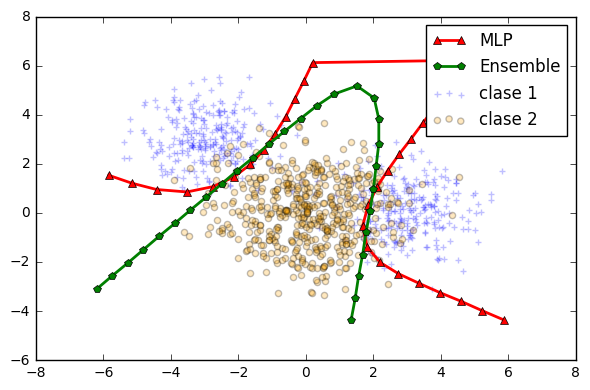

In [31]:
import matplotlib._cntr as cntr

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x = np.array(np.c_[xx.ravel(), yy.ravel()], dtype=config.floatX)
Z1 = mlp.predict(x)
Z2 = ensemble.predict(x)

# Put the result into a color plot
z1 = Z1.reshape(xx.shape)
z2 = Z2.reshape(xx.shape)

def get_contour(x, y, z):
    c = cntr.Cntr(x, y, z)
    level = 0.5
    nlist = c.trace(level, level, 0)
    segs = nlist[:len(nlist)//2]
    x1 = []
    y1 = []
    for seg in segs:
        x1 = np.concatenate((x1, seg[:,0]))
        y1 = np.concatenate((y1, seg[:,1]))
    return x1, y1


xx1, yy1 = get_contour(xx, yy, z1)
xx2, yy2 = get_contour(xx, yy, z2)

fig = plt.figure()
plt.plot(xx1[0::50], yy1[0::50], '-^r', linewidth=2)
plt.plot(xx2[0::50], yy2[0::50], '-pg', linewidth=2)
plt.scatter(x1_samples[:,0],x1_samples[:,1], marker='+', alpha=0.25)
plt.scatter(x2_samples[:,0],x2_samples[:,1], c='orange', marker='o', alpha=0.25)
plt.legend(['MLP', 'Ensemble'] + labels)
plt.tight_layout()

## Plot Models Ensemble

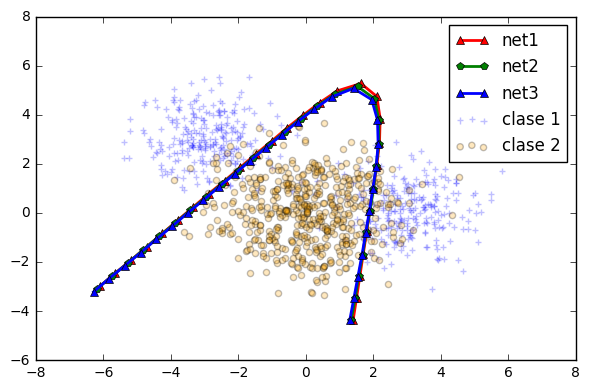

In [32]:
Z21 = ensemble.list_models_ensemble[0].predict(x)
Z22 = ensemble.list_models_ensemble[1].predict(x)
Z23 = ensemble.list_models_ensemble[2].predict(x)

# Put the result into a color plot
z21 = Z21.reshape(xx.shape)
z22 = Z22.reshape(xx.shape)
z23 = Z23.reshape(xx.shape)

xx21, yy21 = get_contour(xx, yy, z21)
xx22, yy22 = get_contour(xx, yy, z22)
xx23, yy23 = get_contour(xx, yy, z23)

fig = plt.figure()
plt.plot(xx21[0::50], yy21[0::50], '-^r', linewidth=2)
plt.plot(xx22[0::50], yy22[0::50], '-pg', linewidth=2)
plt.plot(xx23[0::50], yy23[0::50], '-^b', linewidth=2)
plt.scatter(x1_samples[:,0],x1_samples[:,1], marker='+', alpha=0.25)
plt.scatter(x2_samples[:,0],x2_samples[:,1], c='orange', marker='o', alpha=0.25)
plt.legend(['net1', 'net2', 'net3'] + labels)
plt.tight_layout()